In [1]:
%matplotlib inline
import numpy, xarray
from glob import glob
from sys import stdout
from matplotlib import pyplot
from mpl_toolkits.basemap import Basemap
import seaborn
import cesmutils, plotutils  # some utility functions

In [2]:
# identifier for this comparison case;
# this ID will be used to name the output plots
comparison_id = 'nudge_test'

# cases to plot
cases = (#'FC5.ce12.ne30_ne30.test', 'FC5.ce12.ne30_ne30.nudgeUV',
         'FC5.sp20.ne30_ne30.test', 'FC5.sp20.ne30_ne30.nudgeUV',
         'FSPCAMm.sp20.ne30_ne30.test', 'FSPCAMm.sp20.ne30_ne30.nudgeUV')

# variables to look at
vnames = ('U200', 'V200', 'T200', 'U850', 'V850', 'T850', 'PSL')

# where is the data stored?
cases_root = '/Users/bhillma/gscratch/cesm/archive'
obs_root = '/Users/bhillma/gscratch/era-i/cam.se'

# on what history tapes should we look?
htape = 'h1'

Code to compare multiple cases:

In [7]:
cmap_full = pyplot.get_cmap('plasma')
cmap_diff = pyplot.get_cmap('RdBu_r')
clevels = {
    'U200': numpy.linspace(-100, 100, 21),
    'U850': numpy.linspace(-40, 40, 21),
}
dlevels = {
    'U200': numpy.linspace(-100, 100, 21),
    'U850': numpy.linspace(-40, 40, 21),
}

FC5.sp20.ne30_ne30.test
FC5.sp20.ne30_ne30.nudgeUV
FSPCAMm.sp20.ne30_ne30.test
FSPCAMm.sp20.ne30_ne30.nudgeUV


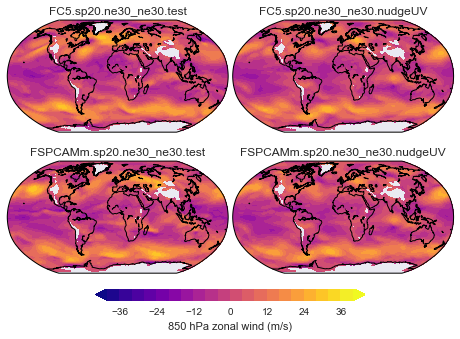

In [4]:
# code to plot full fields
# loop over variables; plot full fields
for ivar, vname in enumerate(('U850',)):  
    figure, axes = pyplot.subplots(2, 2)
    
    # initialize dictionaries to hold statistics to plot
    means = {}
    
    # loop over cases
    for icase, case in enumerate(cases):
        print(case); stdout.flush()

        # find files for this case
        files = sorted(glob('%s/%s/atm/hist/*.cam.%s.*'%(cases_root, case, htape)))
        if len(files) == 0:
            print('No files found for %s'%(case))
            continue

        # open dataset and manually decode times
        ds = xarray.open_mfdataset(files, concat_dim='time', decode_times=False)
        ds.coords['time'] = cesmutils.get_datetimes(ds)
        
        # read data and calculate time-average
        data = cesmutils.get_var(ds, vname)
        data = data.mean('time', keep_attrs=True).squeeze()
        
        # plot full fields
        ax = figure.add_axes(axes.ravel()[icase])
        
        # draw contour plot
        pl = plotutils.plotmap(ds.lon, ds.lat, data.squeeze(),
                               cmap=cmap_full, levels=clevels[vname], 
                               extend='both')
        ax.set_title(case)
        
        # close open files
        ds.close()
    
    figure.subplots_adjust(hspace=0.02, wspace=0.02)
    cb = pyplot.colorbar(pl, ax=axes.ravel().tolist(), orientation='horizontal',
                         label='%s (%s)'%(data.long_name, data.units),
                         fraction=0.04, pad=0.05)

FC5.sp20.ne30_ne30.test
FC5.sp20.ne30_ne30.nudgeUV
FSPCAMm.sp20.ne30_ne30.test
FSPCAMm.sp20.ne30_ne30.nudgeUV


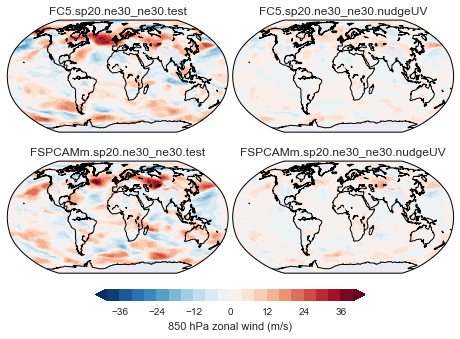

In [8]:
# loop over variables; plot difference fields
for ivar, vname in enumerate(('U850',)):  
    figure, axes = pyplot.subplots(2, 2)
    
    # now, loop over cases
    for icase, case in enumerate(cases):
        print(case); stdout.flush()

        # find files for this case
        files = sorted(glob('%s/%s/atm/hist/*.cam.%s.*'%(cases_root, case, htape)))
        if len(files) == 0:
            print('No files found for %s'%(case))
            continue

        # open dataset and decode times manually
        ds = xarray.open_mfdataset(files, concat_dim='time', decode_times=False)
        ds.coords['time'] = cesmutils.get_datetimes(ds)

        # get date range so we can calculate appropriate averages from obs files
        d1, d2 = ds.time[0], ds.time[-1]

        # get data var
        data = cesmutils.get_var(ds, vname)   
        data = data.mean('time', keep_attrs=True).squeeze()

        # first, find and open obs files (as dask arrays)
        # we do this inside the loop, because in general we might have different
        # obs cases for different variables; i.e., we want to compare with ERA-I
        # or NCEP reanalyses for things like winds, pressure, geopotential height, etc.,
        # but for clouds we will compare with CloudSat, CALIPSO, MISR, ISCCP, MODIS, etc.
        obs_files = sorted(glob('%s/*.nc'%(obs_root)))
        ds_obs = xarray.open_mfdataset(obs_files, concat_dim='time', decode_times=False)
        ds_obs.coords['time'] = cesmutils.get_datetimes(ds_obs)
        
        # concat screws up scalars without time dimension
        for v in ('P0', 'hyam', 'hybm'):
            ds_obs[v] = ds_obs[v].isel(time=0).drop('time')
            
        data_obs = cesmutils.get_var(ds_obs, vname)
        
        # get obs means over appropriate time period
        data_obs = data_obs.sel(time=slice(d1.astype(str), d2.astype(str))).mean('time', keep_attrs=True)
        
        # calculate difference
        data_diff = data - data_obs

        # plot difference
        ax = figure.add_axes(axes.ravel()[icase])
        pl = plotutils.plotmap(ds.lon, ds.lat, data_diff.squeeze(),
                               cmap=pyplot.get_cmap('RdBu_r'),
                               levels=dlevels[vname],
                               extend='both')

        ax.set_title(case)
        
        ds.close()
        ds_obs.close()
    
    figure.subplots_adjust(hspace=0.02, wspace=0.02)
    cb = pyplot.colorbar(pl, ax=axes.ravel().tolist(), orientation='horizontal', 
                         label='%s (%s)'%(data.long_name, data.units),
                         pad=0.05, fraction=0.04)